In [2]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import itertools
import multiprocessing as mp

import sys
sys.path.insert(1, '../')

from config import shuffled_csv, path_exps
from NN import NN_model, Sigmoid, MSE, L2_reg
from NN.utility import batch_train, batch_out, Model_Wrapper
from LBFGS import LBFGS
from testing import multi_run


In [3]:
data = pd.read_csv(shuffled_csv, index_col=0).to_numpy()
data = data[:100, :]
n_samples = data.shape[0]
X_data = data[:, :10]
Y_data = data[:, 10:]

Y_scaler = StandardScaler()
Y_scaled = Y_scaler.fit_transform(Y_data)

# np.random.seed(11)
model = NN_model([10, 20, 20, 2], Sigmoid, MSE)
model.init_weights()
reg_loss = L2_reg(1e-4)

# logging.basicConfig(level="INFO")
f = Model_Wrapper(model, X_data, Y_scaled, reg_loss)
x = model.Weights

experiments_csv = path_exps / Path("LBFGS_grid_search_2.csv")

In [4]:
def run_cell(input):
    m1 = input[0]
    m2 = input[1]
    print(f'Testing m1: {m1}, m2: {m2}', end='')
    solver = LBFGS(eps=1e-5, max_feval=5e4, M=10,m1=m1,m2=m2)
    results = multi_run(solver, f, n=runs)

    log_columns = ["m1", "m2", "f_evals_m", "f_evals_std", "n_failures", "runs"]
    log_data = [m1, m2, results[2], results[3], results[6], runs]
    df = pd.DataFrame([log_data], columns=log_columns)

    if experiments_csv.exists():
        df.to_csv(experiments_csv, mode="a", header=False,index=False)
    else:
        df.to_csv(experiments_csv,index=False)
    print('\t Finished')

In [5]:
runs = 3
m1 = [1e-1,1e-2,1e-3,1e-4]
m2 = [0.9, 0.7, 0.5]
HPs = itertools.product(m1, m2)

# remove HP combinations already explored
if experiments_csv.exists():
    df = pd.read_csv(experiments_csv)
    HPs_new = []
    for m1,m2 in HPs:
        if ((df['m1'] == m1) & (df['m2'] == m2)).any():
            continue
        else:
            HPs_new.append((m1,m2))
    HPs = HPs_new
    
with mp.Pool(processes=8) as pool:
    pool.map(run_cell, HPs)

Testing m1: 0.1, m2: 0.7Testing m1: 0.1, m2: 0.5Testing m1: 0.01, m2: 0.7Testing m1: 0.01, m2: 0.9Testing m1: 0.1, m2: 0.9Testing m1: 0.01, m2: 0.5Testing m1: 0.001, m2: 0.9Testing m1: 0.001, m2: 0.7	 Finished
Testing m1: 0.001, m2: 0.5	 Finished
Testing m1: 0.0001, m2: 0.9	 Finished
Testing m1: 0.0001, m2: 0.7	 Finished
Testing m1: 0.0001, m2: 0.5	 Finished
	 Finished
	 Finished
	 Finished
	 Finished
	 Finished
	 Finished
	 Finished


In [6]:
df = pd.read_csv(experiments_csv)
df.sort_values(by=['f_evals_m'])

,m1,m2,f_evals_m,f_evals_std,n_failures,runs
11,0.0001,0.7,37148.333333,14855.904423,0,3
8,0.0001,0.9,37703.000000,10727.456580,0,3
2,0.0100,0.7,39061.333333,14693.100906,0,3
4,0.1000,0.7,39061.333333,14693.100906,0,3
5,0.0010,0.7,39061.333333,14693.100906,0,3
3,0.0100,0.9,39837.666667,14371.709625,0,3
6,0.0010,0.9,39837.666667,14371.709625,0,3
0,0.0100,0.5,40490.333333,13448.699574,0,3
1,0.1000,0.5,40490.333333,13448.699574,0,3
7,0.1000,0.9,42647.000000,10398.712324,0,3


Text(33.0, 0.5, 'm1')

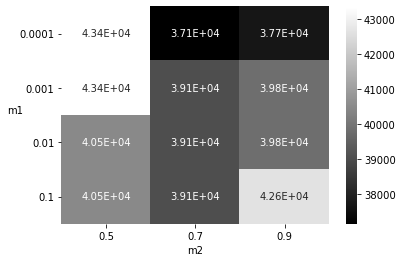

In [7]:
import seaborn as sns
df = pd.read_csv(experiments_csv)
# set failures as nulls
df.loc[df['n_failures'] > 0,'f_evals_m'] = np.nan
df = df.sort_values(by=['m1','m2'])
m1_vals = df['m1'].unique()
m2_vals = df['m2'].unique()
array = df['f_evals_m'].to_numpy()
matrix = array.reshape((len(m1_vals), len(m2_vals)))

ax = sns.heatmap(matrix,cmap='gray', annot=True,fmt='1.2E',
xticklabels=m2_vals, yticklabels=m1_vals)
plt.yticks(rotation=0)
ax.set_xlabel('m2')
ax.set_ylabel('m1',rotation=0)

In [8]:
runs = 3
M_list = [5,20,100,500,2000]
m1 = 0.01
m2 = 0.7

experiments_csv = path_exps / Path("LBFGS_memory_search.csv")
# remove HP combinations already explored
if experiments_csv.exists():
    df = pd.read_csv(experiments_csv)
    M_list_new = []
    for M in M_list:
        if (df['M'] == M).any():
            continue
        else:
            M_list_new.append(M)
    M_list = M_list_new

for M in M_list:
    print(f'Testing M: {M}, m1: {m1}, m2: {m2}', end='')
    solver = LBFGS(eps=1e-4, max_feval=5e4, M=M,m1=m1,m2=m2)
    results = multi_run(solver, f, n=runs)

    log_columns = ["M", "m1", "m2", "f_evals_m", "f_evals_std", "n_failures", "runs", "seconds_m", "seconds_std"]
    log_data = [M, m1, m2, results[2], results[3], results[6], runs, results[4], results[5]]
    df = pd.DataFrame([log_data], columns=log_columns)

    if experiments_csv.exists():
        df.to_csv(experiments_csv, mode="a", header=False,index=False)
    else:
        df.to_csv(experiments_csv,index=False)
    print('\t Finished')

In [9]:
experiments_csv = path_exps / Path("LBFGS_memory_search.csv")
df = pd.read_csv(experiments_csv)
# set failures as nulls
df.loc[df['n_failures'] > 0,'f_evals_m'] = np.nan
df.sort_values(by='f_evals_m')

,M,m1,m2,f_evals_m,f_evals_std,n_failures,runs,seconds_m,seconds_std
13,3000,0.01,0.7,1371.333333,580.712972,0,3,10.946442,0.787353
11,1200,0.01,0.7,1373.333333,536.497489,0,3,10.523646,0.904736
10,800,0.01,0.7,1431.000000,612.996465,0,3,11.494136,0.956184
9,500,0.01,0.7,1433.333333,562.566342,0,3,11.000441,0.468859
14,5000,0.01,0.7,1798.000000,707.715103,0,3,15.178300,1.108940
8,300,0.01,0.7,1821.000000,754.180792,0,3,13.251597,0.386996
15,8500,0.01,0.7,1855.666667,757.406687,0,3,16.651977,2.803262
12,2000,0.01,0.7,1901.000000,731.975865,0,3,15.935054,1.358828
7,150,0.01,0.7,2103.000000,813.663731,0,3,13.788517,0.869150
4,100,0.01,0.7,2667.000000,1023.144499,0,3,16.432585,1.621665


Text(0.5, 0, 'LBFGS Memory (log scale)')

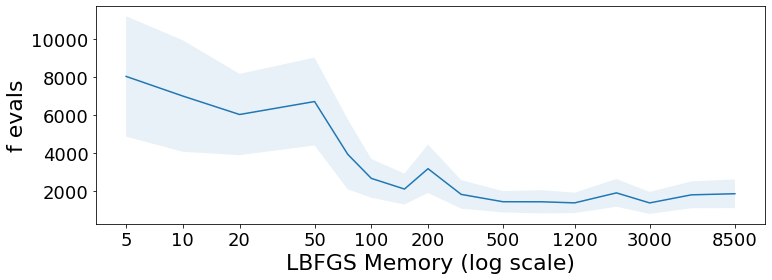

In [10]:
df = df.sort_values(by='M')
x = df['M'].to_numpy()
y = df['f_evals_m']
y_std = df['f_evals_std']

plt.rcParams.update({'font.size': 18,'font.weight':'normal','font.family':'sans-serif'})
removed_indexes = [4,6,8,10,12,14]
x_ticks = np.delete(x,removed_indexes)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x,y)
ax.fill_between(x, y-y_std,y+y_std,alpha=0.1)
plt.xscale('log',base=2)
plt.xticks(x_ticks.astype(int),x_ticks.astype(int))
ax.set_ylabel('f evals', fontsize=22)
ax.set_xlabel('LBFGS Memory (log scale)', fontsize=22)


Text(0.5, 0, 'LBFGS Memory (log scale)')

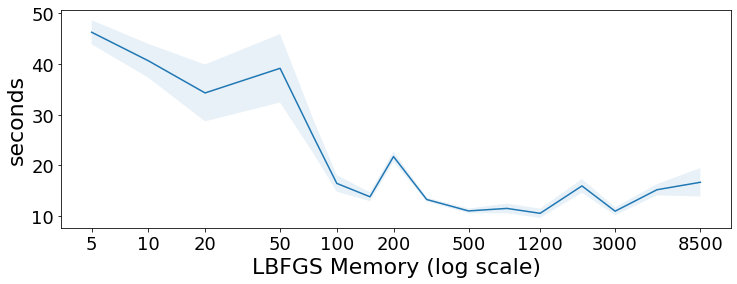

In [11]:
df = df.sort_values(by='M')
x = df['M'].to_numpy()
y = df['seconds_m']
y_std = df['seconds_std']

plt.rcParams.update({'font.size': 18,'font.weight':'normal','font.family':'sans-serif'})
removed_indexes = [4,6,8,10,12,14]
x_ticks = np.delete(x,removed_indexes)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x,y)
ax.fill_between(x, y-y_std,y+y_std,alpha=0.1)
plt.xscale('log',base=2)
plt.xticks(x_ticks,x_ticks)
ax.set_ylabel('seconds', fontsize=22)
ax.set_xlabel('LBFGS Memory (log scale)', fontsize=22)